In [70]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import animation as am
from scipy.integrate import ode 

In [71]:
class Kuramoto():
    
    def __init__(self, epsilon, gamma, sigma):
        self.epsilon = epsilon 
        self.gamma = gamma 
        self.sigma = sigma
        
    def initialise(self, L, T, dt, n_batches): 
        self.L = int(L) 
        self.T = T 
        self.dt = dt 
        self.n_batches = int(n_batches)
        self.step_size = T/(self.n_batches-1)
        self.batch_size = int(np.floor(self.step_size/self.dt))
        self.omegas = self.sigma*np.random.normal(size=(L))

    def evolve(self, verbose=False):
        
        self.res = np.zeros((self.n_batches, self.L))
        theta = np.zeros((self.L))
        n = 0 
        
        small_batch = self.batch_size
        while small_batch > 1000:
            small_batch /= 10 # decrease the amount of time integration at each step
        
        f = lambda t, x: self._det_rhs(x)
        r = ode(f).set_integrator('lsoda', rtol=1e-5, nsteps=small_batch)
        r.set_initial_value(theta, 0)

        for i in range(int((self.T/self.dt)/small_batch)):
            if r.successful():
                if i % int(self.batch_size/small_batch) == 0:
                    self.res[n] = theta
                    if verbose: 
                        print("time step: {} \n".format(n))
                    n += 1
                theta = r.integrate(r.t+self.dt*small_batch)
            
    def add_constant_omega(self, omega):
        omega_t = omega*np.linspace(0, self.T, self.n_batches)
        omega_t = np.expand_dims(omega_t, axis=-1)
        return self.res + omega_t
        
    def _coupling(self, theta): 
        return np.sin(theta) + self.gamma*(1-np.cos(theta))

    def _det_rhs(self, theta): 
        d_theta_1 = np.roll(theta, 1) - theta 
        d_theta_2 = np.roll(theta, -1) - theta 
        return self.epsilon*(self._coupling(d_theta_1)+self._coupling(d_theta_2))+self.omegas 
    
    
class Kuramoto2D(Kuramoto): 
    
    def initialise(self, Lx, Ly, T, dt, n_batches): 
        self.Lx = int(Lx)
        self.Ly = int(Ly)
        self.T = T 
        self.dt = dt 
        self.n_batches = int(n_batches)
        self.step_size = T/(self.n_batches-1)
        self.batch_size = int(np.floor(self.step_size/self.dt))
        self.omegas = self.sigma*np.random.normal(size=(Lx, Ly))
        
        
    def evolve(self, verbose=False):
        
        self.res = np.zeros((self.n_batches, self.Lx, self.Ly))
        theta = np.zeros((self.Lx*self.Ly))
        n = 0 
        
        small_batch = self.batch_size
        while small_batch > 1000:
            small_batch /= 10 # decrease the amount of time integration at each step
            
        f = lambda t, x: self._det_rhs(x)
        r = ode(f).set_integrator('lsoda', rtol=1e-5, nsteps=small_batch)
        r.set_initial_value(theta, 0)

        for i in range(int((self.T/self.dt)/small_batch)):
            if r.successful():
                if i % int(self.batch_size/small_batch) == 0:
                    self.res[n] = theta.reshape((self.Lx, self.Ly))
                    if verbose: 
                        print("time step: {} \n".format(n))
                    n += 1
                theta = r.integrate(r.t+self.dt*small_batch)
        
    def _det_rhs(self, theta): 
        theta = theta.reshape((self.Lx, self.Ly))
        d_thetas = [] 
        for d in [1, -1]:
            for a in [0, 1]: 
                d_thetas.append((np.roll(theta, d, axis=a) - theta))
                
        coupling = sum(map(self._coupling, d_thetas))
        rhs = self.epsilon*coupling + self.omegas
        return rhs.flatten()

In [93]:
epsilon = 1
gamma = 1
sigma = 0.3

L = 256
T = 1e2
dt = 1e-3
n_batches = 200 


model = Kuramoto(epsilon, gamma, sigma)
model.initialise(L, T, dt, n_batches)
model.evolve() 

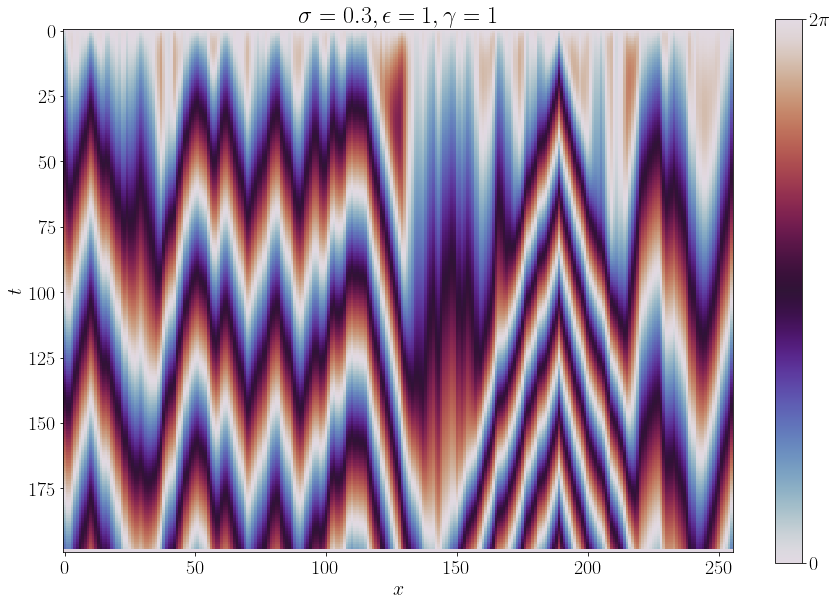

In [94]:
plt.figure(figsize=(15, 10))
plt.rc('font', size=20)
plt.rc('text', usetex=True)
im = plt.imshow(model.res % (np.pi*2), cmap='twilight', vmin=0, vmax=2*np.pi)
cbar = plt.colorbar(im)
cbar.set_ticks([0, 2*np.pi])
cbar.set_ticklabels([r'$0$', r'$2\pi$'])
plt.title(r'$\sigma={}, \epsilon ={}, \gamma ={}$'.format(sigma, epsilon, gamma))
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.show() 

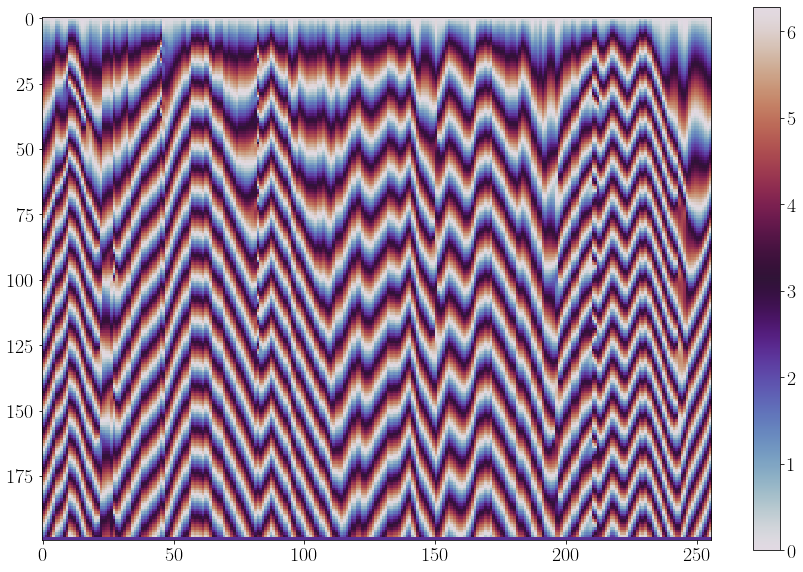

In [90]:
plt.figure(figsize=(15, 10))
plt.rc('font', size=20)
plt.rc('text', usetex=True)
plt.imshow(model.add_constant_omega(0.4) % (np.pi*2), cmap='twilight', vmin=0, vmax=2*np.pi)
plt.colorbar() 
plt.show() 

In [67]:
epsilon = 1 
gamma = 1
sigma = 0.4

Lx = 128
Ly = 40
T = 5e2
dt = 1e-2
n_batches = 100 


model = Kuramoto2D(epsilon, gamma, sigma)
model.initialise(Lx, Ly, T, dt, n_batches)
model.evolve() 

In [69]:
fig = plt.figure(figsize=(20, 5))
low, high = 0, 2*np.pi 

plt.rc('font', size=20)
plt.rc('text', usetex=True)

ims = []
im = plt.imshow(model.res[0].T, vmin=low, vmax=high, animated=True, cmap='twilight')
plt.title(r'$\sigma={}, \epsilon ={}, \gamma ={}$'.format(sigma, epsilon, gamma))
plt.axis('off')
cbar = plt.colorbar(im, shrink=0.6)
cbar.set_ticks([0, 2*np.pi])
cbar.set_ticklabels([r'0', r'$2\pi$'])
plt.tight_layout()
for i in range(model.n_batches):
    xy = model.res[i].T % 2*np.pi 
    im = plt.imshow(xy, vmin=low, vmax=high, animated=True, cmap='twilight')
    plt.axis('off')
    ims.append([im])
ani = am.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)
mywriter = am.FFMpegWriter()
ani.save("movie.mp4", writer=mywriter)
plt.close()
